# Testando coisas da LSTM

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

import sys 
sys.path.insert(0, '../../../scripts')

### 1.2 Bibliotecas para LSTM

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit # para gridsearch com holdout

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
import lstm_model as lstm_model

### 1.3 Bibliotecas dos sistemas caóticos

In [6]:
import timeseries as times
import lorenzsystem as lsys

## 2. Gerando a série temporal do sistema de Lorenz

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original.

In [7]:
t_inicial = 0
t_final = 50
dt = 0.01

In [8]:
estado_inicial = np.array([0.1, 0, 0])

In [9]:
sis_lorenz = lsys.SistemaLorenz(estado_inicial, dt=dt)

In [10]:
solucoes, instantes_temporais = sis_lorenz.calcular(t_inicial = t_inicial, t_final = t_final)

In [11]:
x = solucoes[:, 0]
y = solucoes[:, 1]
z = solucoes[:, 2]

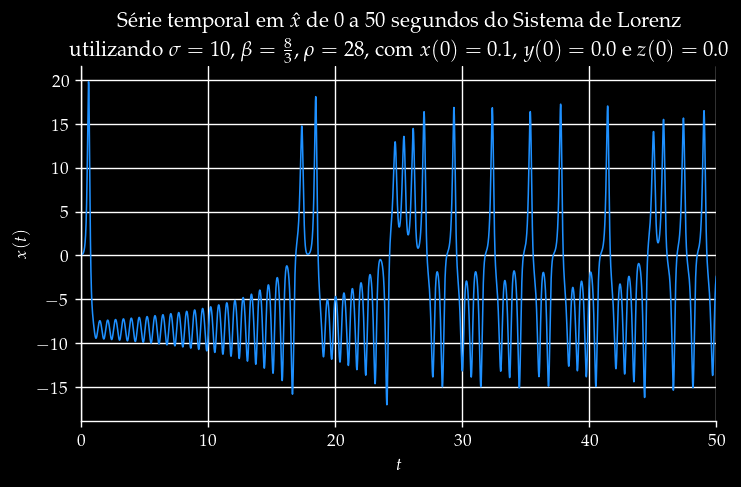

In [12]:
fig, ax = plt.subplots()
ax.set_title("Série temporal em $\hat{x}$ de 0 a 50 segundos do Sistema de Lorenz\n utilizando $\sigma = 10$, " + r"$\beta =\frac{8}{3}$, " + r"$\rho=28$, com " + "$x(0) =$ " + str(estado_inicial[0]) + ", $y(0) = $ " + str(estado_inicial[1]) + " e $z(0) =$ " + str(estado_inicial[2]))
ax.plot(instantes_temporais, x, color='DodgerBlue', linewidth=0.9)

ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(0,50)
ax.grid(True)

fig.tight_layout()
sns.despine()
plt.show()

### Treino com o melhor modelo

#### Dados de entrada

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
x = solucoes[:, 0]
scaler = MinMaxScaler(feature_range=(-1,1))
x = scaler.fit_transform(x.reshape(-1,1)).reshape(len(solucoes[:, 0]), )

#### Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [15]:
K = 4
L = 3
tam_teste = 0.15
tam_val = 0.1

In [16]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)
serie_temporal.criar_matrizes()

In [22]:
X_treino, X_teste, X_val, y_treino, y_teste, y_val = serie_temporal.dividir_treino_teste_validacao(tam_teste=tam_teste, tam_val=tam_val)

#### Ajuste no modelo

In [36]:
model = lstm_model.ModeloLSTM(input_shape = (K, 1), name='LSTM-logistic')

In [37]:
model.criar_modelo(n_units=15, init_mode='glorot_uniform')

In [38]:
model.montar(learning_rate=0.003)

In [39]:
model.visualizar()

Model: "LSTM-logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_lstm (LSTM)           (None, 15)                1020      
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.treinar(X_treino, X_val, y_treino, y_val, batch_size=4)

Epoch 1/100
952/952 [==============================] - 3s 2ms/step - loss: 0.1036 - val_loss: 0.0511
Epoch 2/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0417 - val_loss: 0.0455
Epoch 3/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0355 - val_loss: 0.0350
Epoch 4/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0239 - val_loss: 0.0124
Epoch 5/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 6/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 7/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 8/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 9/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 10/100
952/952 [==============================] - 2s 2ms/step - loss: 0.0054 - val_lo

## Teste com o melhor modelo

In [41]:
y_pred = model.predicao(X_teste, scaler=scaler)

### Desfazendo o *MinMaxScaler* nos dados de teste originais

In [42]:
y_teste = scaler.inverse_transform(y_teste)

### Gráfico

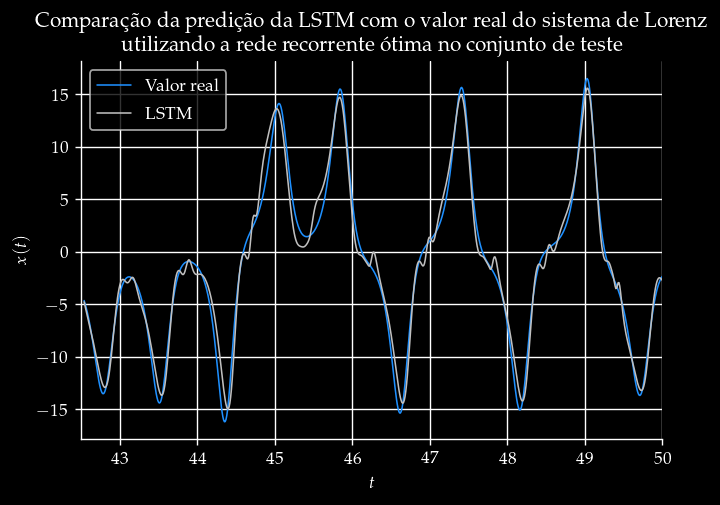

In [45]:
fig, ax = plt.subplots()
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste):,], y_teste, color='DodgerBlue', label='Valor real', linewidth=0.9)
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste):,], y_pred, color='Silver', label='LSTM', linewidth=0.9)

ax.set_title("Comparação da predição da LSTM com o valor real do sistema de Lorenz\n utilizando a rede recorrente ótima no conjunto de teste")
ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(42.5, 50)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()
fig.savefig("../../../images/lstm/performance/lstm-vs-lorenz.png")

### Erro Quadrático Médio

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
mse = mean_squared_error(y_teste, y_pred)
print("MSE = " + str(mse))

MSE = 0.0024214463414923724


### Salvando o Modelo

In [61]:
model.salvar("../../../models/lstm/lstm-lorenz", h5="ON")

O modelo foi salvo!


## Teste do método $\verb|avaliar()|$

In [17]:
model = lstm_model.ModeloLSTM(input_shape = (K, 1), name='LSTM-logistic')

In [18]:
model.criar_modelo(n_units=15, init_mode='glorot_uniform')

In [19]:
model.montar(learning_rate=0.003)

In [20]:
model.visualizar()

Model: "LSTM-logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_lstm (LSTM)           (None, 15)                1020      
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.avaliar(X_treino, X_val, X_teste, y_treino,
              y_val, y_teste, n_repeticoes = 3, batch_size=4,
              early_stopping="ON", epochs=100,
              scaler=scaler)

Testando para a repetição de número 0
MSE para essa repetição: 0.010149795467900046
Testando para a repetição de número 1
MSE para essa repetição: 0.0050860942211904975
Testando para a repetição de número 2
MSE para essa repetição: 0.0031334208512203503
Média do erro quadrático médio: 0.006123103513436964

Desvio padrão do erro quadrático médio: 0.0036213145948054454



(0.006123103513436964, 0.0036213145948054454)

## Testes com o formato de entrada

### One-to-one